## Predicting DC PCSB's Annual Performance Management Framework (PMF) Tiers

Predicting a school's Tier based on two years of performance data

[Description of Project]

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Read & Clean Data

In [48]:
pmf_data = pd.read_csv('../pmf-predictions/pmf_data_final.csv')

In [49]:
## set index
pmf_data.set_index(['school_code','school_name']);
## preview data
pmf_data.head()

,school_code,school_name,school_year,pmf_score,pmf_tier,framework,ward,years_in_operation,money_spent_on_personnel_%,asian_%,...,growth_assessment,ela_growth_%,math_growth_%,achievement_assessment,ela_3+_%,ela_4+_%,math_3+_%,math_4+_%,isa_%,reenrollment_%
0,217,Achievement Preparatory Academy PCS - Wahler P...,2018-2019,60.10%,2.0,PK-8,8,7,51.360076,0.0,...,NWEA MAP,63.5,65.0,PARCC,32.3,14.5,48.4,19.4,88.8,64.4
1,1100,Achievement Preparatory Academy PCS - Wahler P...,2018-2019,35.30%,2.0,PK-8,8,12,51.360076,0.0,...,PARCC,41.1,42.5,PARCC,39.9,19.5,35.0,12.5,91.3,80.2
2,3068,BASIS DC PCS,2018-2019,84.30%,1.0,PK-8,2,8,57.726752,7.2,...,PARCC,62.5,52.5,PARCC,94.6,79.5,88.7,67.6,96.6,90.0
3,142,Bridges PCS,2018-2019,50.00%,2.0,PK-8,5,15,68.766596,1.2,...,PARCC,46.1,42.9,PARCC,43.2,19.4,51.4,19.6,93.6,78.4
4,184,Capital City PCS - Lower School,2018-2019,56.70%,2.0,PK-8,4,20,70.450341,1.9,...,PARCC,51.8,43.0,PARCC,47.5,15.2,52.5,28.3,93.6,89.9


In [50]:
##Remove percent sign from PMF Score Column
pmf_data['pmf_score'] = pmf_data['pmf_score'].str.replace('%','')
## Convert PMF Score to a numeric feature
pmf_data['pmf_score'] = pd.to_numeric(pmf_data['pmf_score'])
pmf_data['pmf_score'].dtypes

dtype('float64')

In [51]:
## fill reenrollment rates & student growth with average
pmf_data['reenrollment_%'].fillna(pmf_data['reenrollment_%'].mean(),inplace=True)
pmf_data['ela_growth_%'].fillna(pmf_data['ela_growth_%'].mean(),inplace=True)
pmf_data['math_growth_%'].fillna(pmf_data['math_growth_%'].mean(),inplace=True)
## remove schools with no tier
pmf_data.dropna(subset= ['pmf_tier'], inplace=True)
## Check for zero nulls 
pmf_data.isnull().sum().sum()

0

In [52]:
## Map assessments to numeric values
pmf_data['growth_assessment'] = pmf_data.growth_assessment.map({'PARCC':0, 'NWEA MAP':1})

### Feature Selection
#### Initial Determination of Features Not to Include
Before using a correlation matrix, I was able to make a few determinations about features I would <i>not</i> include.
- <b>PMF Score</b> corresponds to a Tier naturally. A score above 65.0% is Tier 1, between 35.0% and 65.9% is Tier 2, and a Tier 3 is anything 34.9% and below. 
- <b> Race or Ethnicity Values </b> are not used because the DC Charte Sector is not particularly diverse. Special population values such as students with disabilities, english learners, and at-risk students are more useful.

#### Feature Selection Using a Correlation Matrix and Heatmap
The correlation heatmap revealed a few details about what features I should include and/or exclude. The PMF Tier is highly correlated with all of the academic measures such as ELA Growth, Math Achievement, ELA Achievement, etc. Growth is a strong predictor of success on the framework. Achievement on the state assessment (represented here by students scoring level 3+ or 4+) is also a strong predictor. Since level 3+ and level 4+ is just a repackaging of the data, these are substantially similar measures. I chose one for each subject to reduce multicolinearity. 

Initial Features selected:
- Ward
- Money Spend on Personnel (Salaries and Benefits)
- SPED (%)
- ELL (%)
- At-Risk (%)
- ELA Growth (%)
- Math Growth (%)
- ELA %4+
- Math %3+
- Reenrollment (%)

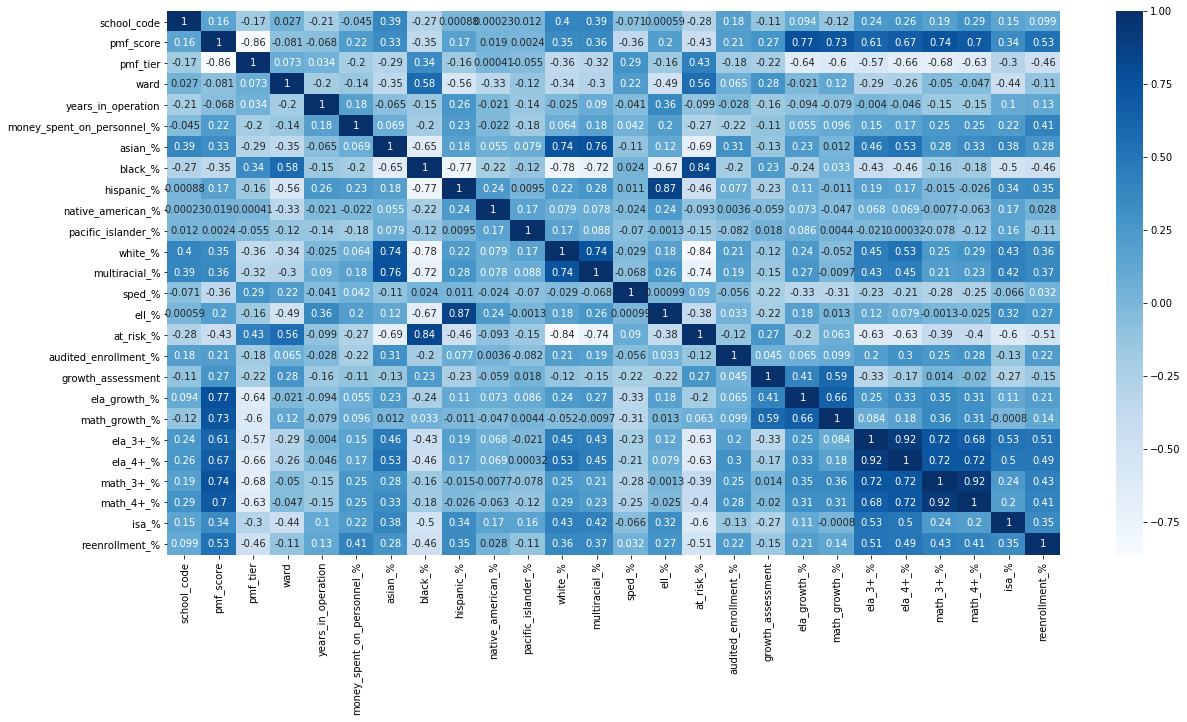

In [54]:
plt.figure(figsize=(20,10))
sns.heatmap(pmf_data.corr(),annot = True, cmap = 'Blues');

In [74]:
## create feature columns object
feature_cols = ['ward','money_spent_on_personnel_%','sped_%','ell_%','at_risk_%','ela_growth_%','math_growth_%',
               'ela_4+_%','math_3+_%','reenrollment_%']

## Select features and target variable
X = pmf_data[feature_cols]
y = pmf_data.pmf_tier

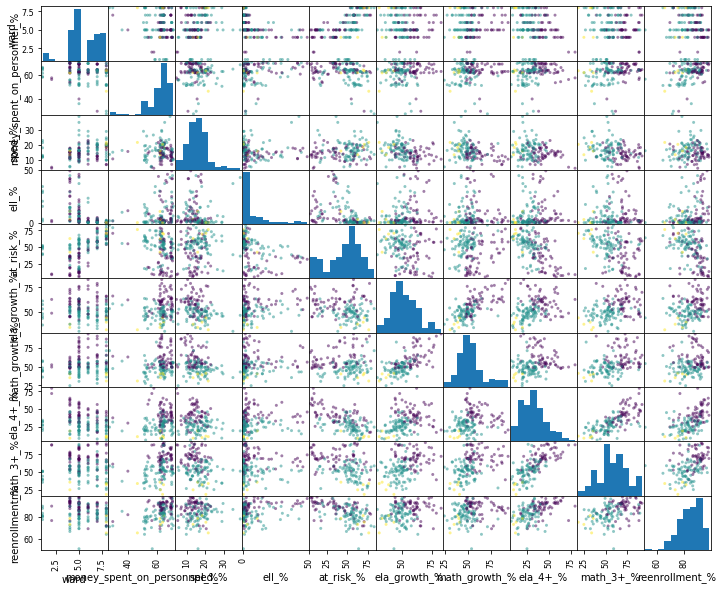

In [72]:
# Scatter matrix of all features, colored by species.
pd.plotting.scatter_matrix(X, c=pmf_data.pmf_tier, figsize=(12, 10));

### Build Model

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

In [76]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [77]:
y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

0.8648648648648649
